In [24]:
# this has three hidden layers !!! 

In [1]:
# Package imports
import numpy as np
from sklearn.model_selection import train_test_split

# Matplotlib is a matlab like plotting library
import matplotlib
from matplotlib import pyplot as plt
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating |datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from scipy.stats import gaussian_kde

In [2]:
# importing dataset
# import data
from DataExtraction import dataNoMass
from DataExtraction import dataWithP2
from DataExtraction import dataWithP2E2 
from DataExtraction import dataWithMass 
#from DataExtraction import p2E2 as data
from DataExtraction import p2NegE2 as data
#from DataExtraction import labels
from DataExtraction import labels2D as labels
data = np.array(data)
labels = np.array(labels)

In [3]:
# split data 
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5, test_size=0.5, random_state=42)

In [4]:
# normalize/scale data here
runSum = 0
for e in train_data:
    runSum+=e
avgE2 = runSum/(len(train_data))

train_data = train_data/avgE2
test_data = test_data/avgE2

In [5]:
# any other data manipulations/printing here

In [6]:
# define softmax
def softmax(z):
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [7]:
# define loss functions

# softmax loss
def softmax_loss(y,y_hat):
    # clipping value 
    minval = 0.000000000001
    # number of samples
    m = y.shape[0]
    # loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula 
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss

# crossentropy loss
def crossEntropy_loss(y, y_hat):
    m = y.shape[0]
    if y.all() == 1:
        return -1/m * np.sum(np.log(y_hat))
    else:
        return -1/m * np.sum(np.log(1 - y_hat))

# mse loss
def mse_loss(y, y_hat):
    m = y.shape[0]
    return np.sum((y_hat - y)**2) / m


In [8]:
# define derivatives

# loss derivative
def loss_derivative(y,y_hat):
    return (y_hat-y)

# tanh derivative
def tanh_derivative(x):
    return (1 - np.power(x, 2))


In [9]:
# forward propogation
def forward_prop(model, a0):
    
    #Start Forward Propagation
    
    # Load parameters from model (1)
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3'], model['W4'], model['b4']
    
    # Do the first Linear step 
    # Z1 is the input layer x times the dot product of the weights + our bias b
    z1 = a0.dot(W1) + b1
    
    # Put it through the first activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    # Third linear step
    z3 = a2.dot(W3) + b3
    
    # Third activation function
    a3 = np.tanh(z3)
    
    # Fourth linear step
    z4 = a3.dot(W4) + b4
    
    # For the Third linear activation function we use the softmax function, 
    # either the sigmoid of softmax should be used for the last layer
    a4 = softmax(z4)
    
    #Store all results in these values
    cache = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2,'a3':a3,'z3':z3,'a4':a4,'z4':z4}
    return cache
    

In [10]:
# backward propogation
def backward_prop(model, cache, y):

    # Load parameters from model (2)
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3'], model['W4'], model['b4']
    
    # Load forward propagation results
    a0,a1,a2,a3,a4 = cache['a0'],cache['a1'],cache['a2'],cache['a3'],cache['a4']
    
    # Get number of samples
    m = y.shape[0]
    
    #calculate loss derivative with respect to output
    
    # Calculate loss derivative with respect to output
    dz4 = loss_derivative(y=y,y_hat=a4)

    # Calculate loss derivative with respect to third layer weights
    dW4 = 1/m*(a3.T).dot(dz4) #dW2 = 1/m*(a1.T).dot(dz2) 
    
    # Calculate loss derivative with respect to third layer bias
    db4 = 1/m*np.sum(dz4, axis=0)
    
    # Calculate loss derivative with respect to second layer
    dz3 = np.multiply(dz4.dot(W4.T) ,tanh_derivative(a3))
    
    # Calculate loss derivative with respect to second layer weights
    dW3 = 1/m*np.dot(a2.T, dz3)
    
    # Calculate loss derivative with respect to second layer bias
    db3 = 1/m*np.sum(dz3, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz2 = np.multiply(dz3.dot(W3.T) ,tanh_derivative(a2))
    
    # Calculate loss derivative with respect to first layer weights
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    # Calculate loss derivative with respect to first layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    dz1 = np.multiply(dz2.dot(W2.T),tanh_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    db1 = 1/m*np.sum(dz1,axis=0)
    
    # Store gradients
    grads = {'dW4':dW4,'db4':db4, 'dW3':dW3, 'db3':db3, 'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads


In [11]:
# TRAINING PHASE
# this takes in the number of nodes in each layer
def initialize_parameters(input_dim, l1_dim, l2_dim, l3_dim, output_dim):
    
    # first layer weights
    W1 = 2 * np.random.randn(input_dim, l1_dim) -1
    # first layer bias
    b1 = np.zeros((1,l1_dim))
    
    # second layer weights
    W2 = 2 * np.random.randn(l1_dim, l2_dim) -1
    # second layer bias
    b2 = np.zeros((1, l2_dim))
    
    # third layer weights
    W3 = 2 * np.random.randn(l2_dim, l3_dim) -1
    # third layer bias
    b3 = np.zeros((1, l3_dim))
    
    # fourth layer weights (output layer)
    W4 = 2 * np.random.randn(l3_dim, output_dim)
    # fourth layer bias (output layer)
    b4 = np.zeros((1, output_dim))
    
    # package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3, 'W4':W4, 'b4':b4}
    return model

def update_parameters(model, grads, learning_rate):
   # Load parameters from model (3)
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3'], model['W4'], model['b4']
    
    # update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    W3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']
    W4 -= learning_rate * grads['dW4']
    b4 -= learning_rate * grads['db4']
    
    # store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3, 'W4':W4, 'b4':b4}
    return model

# predict
def predict(model, x):
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = c['a4']
    # plotArr.append([x, y_hat]) #added to make plot
    return y_hat

# calculate accuracy
def calc_accuracy(model,x,y):
    # Get total number of examples
    m = y.shape[0]
    # Do a prediction with the model
    pred = predict(model,x)
    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)
    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred-y))
    # Calculate accuracy
    return (m - error)/m * 100

# train
# change numbner of epochs here
def train(model,X_,y_,learning_rate, epochs=2001, print_loss=False):
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
    
        a4 = cache['a4'] 
        thisLoss = mse_loss(y_,a4) # set loss function here
        losses.append(thisLoss)
        y_hat = predict(model,X_) # getting rid of this because it's wrong
        y_true = y_.argmax(axis=1)
        accur = accuracy_score(a4,train_labels)
        train_accuracies.append(accur)
        
        if i % 50 == 0:
            placeholderVar = accuracy_score(a4, train_labels)
            test_accuracy = accuracyOfModel(model, test_data, test_labels)
            test_accuracies.append(test_accuracy)
            test_num.append(i)
        #Printing loss & accuracy every 100 iterations
        if print_loss and i % 300==0:
            print('Loss after iteration',i,':',thisLoss)
            print('Train Accuracy after iteration',i,':',accur*100,'%')
            print('Test Accuracy after iteration',i,':',test_accuracy*100,'%')
    return model
    
# TESTING PHASE
# test the accuracy of any model
def accuracyOfModel(_model, _testData, _testLabels):
    y_pred = predict(_model,_testData) # make predictions on test data
    y_true = _testLabels # get usable info from labels
    return accuracy_score(y_pred, y_true)

def accuracy_score(_outputNodes, _labels):
    for i in range(len(_outputNodes)-1):
        if _outputNodes[i][0]>.5:
            _outputNodes[i]=[1,0]
        else:
            _outputNodes[i]=[0,1]
    numWrong = np.count_nonzero(np.subtract(_outputNodes,_labels))/2
    return (len(_outputNodes)-numWrong)/len(_outputNodes)


In [16]:
# plotArr = []
losses = []
train_accuracies = []
test_accuracies = []
test_num = []
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(input_dim=2, l1_dim=5, l2_dim=5, l3_dim=5, output_dim=2)
model = train(model,train_data,train_labels,learning_rate=0.01,epochs=12101,print_loss=True)

Loss after iteration 0 : 0.9477521662308858
Train Accuracy after iteration 0 : 50.51452554929079 %
Test Accuracy after iteration 0 : 50.883669186619805 %
Loss after iteration 300 : 0.4982457468206001
Train Accuracy after iteration 300 : 49.96081009329726 %
Test Accuracy after iteration 300 : 50.23893201183283 %
Loss after iteration 600 : 0.49794303978947135
Train Accuracy after iteration 600 : 49.978508760840434 %
Test Accuracy after iteration 600 : 50.26674420368637 %
Loss after iteration 900 : 0.4978262467072445
Train Accuracy after iteration 900 : 50.008849333771586 %
Test Accuracy after iteration 900 : 50.309726682005504 %
Loss after iteration 1200 : 0.49776365470253114
Train Accuracy after iteration 1200 : 50.036661525625135 %
Test Accuracy after iteration 1200 : 50.32489696847109 %
Loss after iteration 1500 : 0.4977248880591599
Train Accuracy after iteration 1500 : 50.0568885742459 %
Test Accuracy after iteration 1500 : 50.35018077924705 %
Loss after iteration 1800 : 0.4976992689

Text(0, 0.5, 'Score')

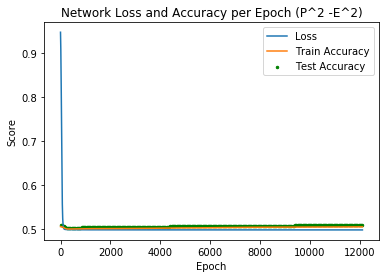

In [19]:
# plt.plot(losses, label="Loss")
plt.plot(train_accuracies, label="Train Accuracy")
plt.scatter(test_num, test_accuracies, label="Test Accuracy", s=6, color="green")
plt.legend()
plt.title("Network Loss and Accuracy per Epoch (P^2 -E^2)")
plt.xlabel("Epoch")
plt.ylabel("Score")